# Assignment
## DeepFake Voice Detection

**Dataset: 'In-the-Wild':**

* dataset of audio deepfakes (and corresponding benign audio) for a set of politicians and other public figures
* collected from publicly available sources such as social networks and video streaming platforms.
* from 58 celebrities and politicians bona-fide and spoofed audio was collected (in total 20.8 hours of bona-fide and 17.2 hours of spoofed audio). On average, there are 23 minutes of bona-fide and 18 minutes of spoofed audio per speaker.

source: https://deepfake-total.com/in_the_wild

In [ ]:
! pip install scikeras
! pip install noisereduce

In [ ]:
#standard imports
import zipfile as zp
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
# Import the Google Colab drive module to interact with Google Drive
from google.colab import drive
#imports audio processing
import librosa
#imports for data preprocessing
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import noisereduce as nr
#imports for model training
import keras
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.callbacks import ProgbarLogger
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Dropout, MaxPooling2D, BatchNormalization, AveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam
from keras.metrics import F1Score
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Mount Google Drive to the Colab environment, allowing access to files in Drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# 1. Understand the data

* visualize distribution of data

  

In [ ]:
def load_data(dataset_path):
    #extract zipfile
    zf = zp.ZipFile(dataset_path + 'release_in_the_wild.zip')
    #read csv-file into dataframe
    df = pd.read_csv(zf.open('release_in_the_wild/meta.csv'), sep=',')
    return df

In [ ]:
df = load_data('/content/drive/My Drive/Colab_Notebooks/NLP/')

In [ ]:
df.head()

,file,speaker,label
0,0.wav,Alec Guinness,spoof
1,1.wav,Alec Guinness,spoof
2,2.wav,Barack Obama,spoof
3,3.wav,Alec Guinness,spoof
4,4.wav,Christopher Hitchens,bona-fide


In [ ]:
df.describe()

,file,speaker,label
count,31779,31779,31779
unique,31779,54,2
top,31778.wav,Barack Obama,bona-fide
freq,1,3636,19963


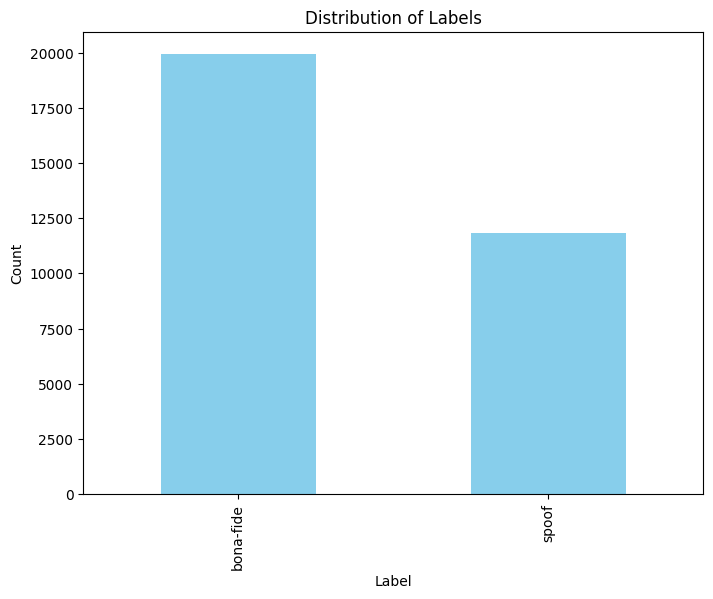

In [ ]:
plt.figure(figsize=(8, 6))
df['label'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# 1.1 Problem: imbalanced dataset

* the distribution of the dataset is imbalanced
* classes are not represented equally (more labels with bona-fide, than spoof)

In [ ]:
#creating a balanced dataset with undersampling-method of the majority class
def under_sample(df, target_column):
    # divide the classes
    classes = df[target_column].unique()
    # group the dataset by the classes
    grouped = [df[df[target_column] == cls] for cls in classes]
    # get reference for the class with less label
    min_size = min([len(group) for group in grouped])
    # undersample the majority class
    sampled_groups = [resample(group, replace=False, n_samples=min_size, random_state=42)
                      for group in grouped]

    # get balanced dataframe
    balanced_df = pd.concat(sampled_groups).sample(frac=1, random_state=42).reset_index(drop=True)

    return balanced_df

In [ ]:
df = under_sample(df,'label')

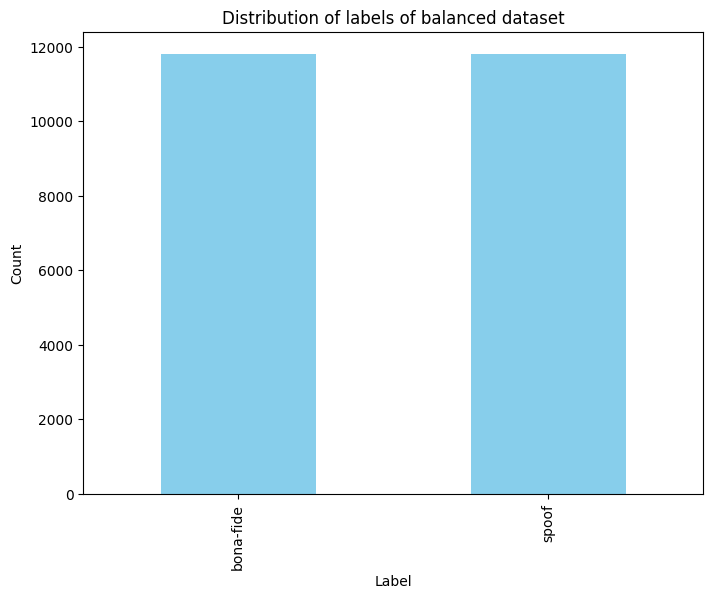

In [ ]:
plt.figure(figsize=(8, 6))
df['label'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of labels of balanced dataset')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [ ]:
len(df)

23632

# 1.2 Problem: RAM not enough for GridSearch

* GridSearch not possible with 10% of Train Data - just 5%
* need to get a balanced dataset with 5% of the dataset

In [ ]:
#get balanced dataset for GridSearch
def extract_files(dataset_path, df):
    audios = []
    audios_norm = []
    sr_list = []
    file_list = []
    file_count = 0  # initialize counter
    max_files = int(len(df) * 0.05)
    num = int(max_files/2)

    # subset for every label
    spoof_subset = df[df['label'] == 'spoof'].sample(n=num, random_state=42)
    bona_fide_subset = df[df['label'] == 'bona-fide'].sample(n=num, random_state=42)
    # combine subsets
    subset = pd.concat([spoof_subset, bona_fide_subset])

    #extract zipfile
    zf = zp.ZipFile(dataset_path + 'release_in_the_wild.zip')
    # iterate over all files in zip-archive
    for filename in zf.namelist():
      filename_split = filename.split('/')[1] #get only the filename to match with df
      if filename.endswith('.wav') and filename_split in subset['file'].values:
            with zf.open(filename) as file:
            #load audio files
              audio, sr = librosa.load(file, duration=0.8) #duration to get the same shape for every file
              # normalize audio waveform
              audio_norm = librosa.util.normalize(audio)

              #append filename to list
              file_list.append(filename_split)
              #append audio from wav-file to list
              audios.append(audio)
              audios_norm.append(audio_norm)
              sr_list.append(sr)

              # increade counter and break if 100
              file_count += 1
              if file_count >= max_files:
                  break

    return subset, audios, audios_norm, sr_list, file_list

In [ ]:
# call the predefined function
db_path = '/content/drive/My Drive/Colab_Notebooks/NLP/'
subset_grid, audios, audios_norm, sr_list, file_list = extract_files(db_path, df)

In [ ]:
len(subset_grid)

1180

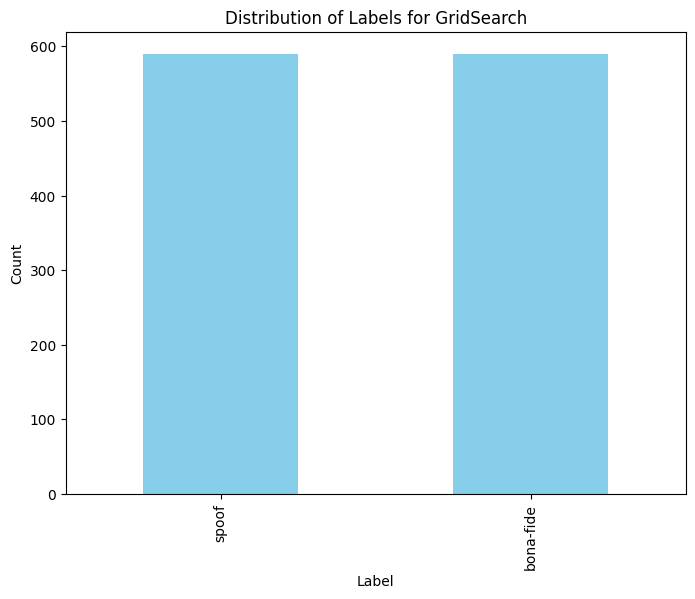

In [ ]:
plt.figure(figsize=(8, 6))
subset_grid['label'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Labels for GridSearch')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# 2. Feature Extraction
* load audio of balanced_data (get metadata and data of audio files)
* extract mel-scaled spectrogram
* create new dataframe (mapping new features of the audios with the classes from csv-file)

In [ ]:
#extract files and get features
def extract_files(dataset_path, df, NMELS):
    audios = []
    sr_list = []
    file_list = []
    features_mel = []
    features_mfcc = []

    #extract zipfile
    zf = zp.ZipFile(dataset_path + 'release_in_the_wild.zip')
    # iterate over all files in zip-archive
    for filename in zf.namelist():
      filename_split = filename.split('/')[1] #get only the filename to match with df
      if filename.endswith('.wav') and filename_split in df['file'].values:
            with zf.open(filename) as file:
            #load audio files
              audio, sr = librosa.load(file, sr=None, duration=4.0)
              audio = nr.reduce_noise(audio, sr=sr)

              #extract mel spectograms
              mel = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=NMELS, n_fft=2048, hop_length=512, fmin=20,fmax=8000)
              # normalize spectogram into dezibel
              mel_spec = librosa.power_to_db(mel, ref=np.max)
              mfcc = librosa.feature.mfcc(S=mel_spec)

              #append filename to list
              file_list.append(filename_split)
              #append audio from wav-file to list
              audios.append(audio)
              #append sample rate to list
              sr_list.append(sr)
              # append spectogram into list
              features_mel.append(mel_spec)
              #append mfcc into list
              features_mfcc.append(mfcc)

    return features_mel, audios, sr_list, file_list, features_mfcc

In [ ]:
# call the predefined function
db_path = '/content/drive/My Drive/Colab_Notebooks/NLP/'
nmels = 128
features_mel, audios, sr_list, file_list, features_mfcc = extract_files(db_path, df, nmels)

# 2.1. Feature Expansion
* padding of the spectograms to get the same length of each

In [ ]:
# get the max length of all spectograms in the dataset
max_length = max(spec.shape[1] for spec in features_mel)

# Padding-Function - adding the shorter spectograms to the max length
def pad_spectrograms(spectrograms, max_length):
    padded_spectrograms = []
    for spec in spectrograms:
      if spec.shape[1] < max_length:
        # calculate how much 0 values are needed
        pad_width = max_length - spec.shape[1]
        # pad with zeros along the time axis
        padded_spec = np.pad(spec, ((0, 0), (0, pad_width)), mode='constant')
      else:
          padded_spec = spec[:, :max_length]
      padded_spectrograms.append(padded_spec)

    return np.array(padded_spectrograms)

In [ ]:
padded_spectrograms = pad_spectrograms(features_mel, max_length)
padded_mfcc = pad_spectrograms(features_mfcc, max_length)

# 3. Save outputs

In [ ]:
#get new Dataframe with the features of the audio
data_dict = {
    'filename': file_list,
    'audio': audios,
    'sr': sr_list,
    'mel_spec': features_mel,
    'mfcc': features_mfcc,
    }

# define datatypes
dtype_dict = {
    'filename': 'string',
    'audio': object,
    'sr': 'int64',
    'mel_spec': object,
    'mfcc': object,
}
#join new df with csv-file from dataset to get the speaker and the label
data = pd.DataFrame(data_dict).astype(dtype_dict)
data = data.join(df.set_index('file'), on='filename')

In [ ]:
data_path = '/content/drive/My Drive/Colab_Notebooks/'
#save dataframe as pickle file
data.to_pickle(data_path + 'dataset_training.pkl')

In [ ]:
data

,filename,audio,sr,mel_spec,mfcc,speaker,label
0,6418.wav,"[-0.015278615, -0.01640311, -0.009635433, -0.0...",16000,"[[-42.44505, -45.111153, -47.193775, -43.70585...","[[-613.2701, -579.7732, -576.63574, -571.9158,...",Christopher Hitchens,bona-fide
1,30272.wav,"[0.0012182709, 0.002052115, 0.0011695818, 0.00...",16000,"[[-38.235313, -35.96184, -37.85099, -37.82351,...","[[-754.7565, -725.5813, -631.6178, -509.45306,...",Alec Guinness,bona-fide
2,15101.wav,"[-0.00065647846, -0.00066540285, -0.0008206547...",16000,"[[-62.774696, -58.70765, -62.289818, -61.77743...","[[-824.82587, -799.9828, -797.9859, -797.0536,...",Donald Trump,bona-fide
3,6602.wav,"[-0.00022388496, -0.00070374255, -0.0010875033...",16000,"[[-60.541306, -58.839928, -57.338486, -59.3593...","[[-798.5138, -779.91583, -791.75244, -799.2879...",Bill Clinton,bona-fide
4,23183.wav,"[-0.0015474726, 4.294394e-05, 0.0030172325, -0...",16000,"[[-70.9849, -75.84583, -80.0, -77.43429, -78.1...","[[-801.8516, -812.1461, -871.8167, -884.9914, ...",Alexandria Ocasio-Cortez,spoof
...,...,...,...,...,...,...,...
23627,6484.wav,"[-0.0005668776, -0.0007535114, -0.0007615502, ...",16000,"[[-49.05974, -45.221306, -45.939728, -49.44788...","[[-845.9817, -834.1749, -836.52924, -837.1386,...",Winston Churchill,spoof
23628,19257.wav,"[0.0005152775, 0.0006611512, 0.00072437373, 0....",16000,"[[-63.64389, -62.973503, -64.999275, -65.46776...","[[-830.5892, -804.8613, -800.0849, -803.4112, ...",Barack Obama,bona-fide
23629,7644.wav,"[-0.0010177712, -0.0014585236, -0.00046883096,...",16000,"[[-31.217175, -28.032478, -28.47004, -26.02241...","[[-565.17914, -465.8003, -411.2904, -404.62708...",Alec Guinness,bona-fide
23630,27148.wav,"[0.00040143658, 0.00040509063, 0.00037034843, ...",16000,"[[-67.428604, -61.03746, -60.06256, -61.748085...","[[-854.84064, -837.12445, -837.147, -839.45776...",Barack Obama,bona-fide


In [ ]:
def save_outputs(features, df, name, data_path):
  # save data as .npz-Datei
  np.savez_compressed(data_path + f'data_{name}.npz', spectrograms=features, labels=df['label'])
  return

In [ ]:
data_path = '/content/drive/My Drive/Colab_Notebooks/NLP/'
#save dataframe as pickle file
data.to_pickle(data_path + 'red_noise_dataset_training.pkl')
#save outputs
save_outputs(padded_spectrograms, data, 'melspec_red', data_path)
save_outputs(padded_mfcc, data, 'mfcc_red', data_path)

# 4. Visualization of the new features

In [ ]:
def visualize_data(df, typ):
  # filter and get indizes for the labels
  index_spoof = df[df['label'] == 'spoof'].index.tolist()
  index_bona_fide = df[df['label'] == 'bona-fide'].index.tolist()

  if typ == 'audio':
    # subplots
    plt.figure(figsize=(12, 4))

    # first plot
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, plot 1
    #audio_data = np.fromstring(df['audio'][index_bona_fide[0]][1:-1], dtype=float, sep=',')
    #audio = librosa.amplitude_to_db(audio_data, ref = np.max)
    plt.plot(df['audio'][index_bona_fide[0]])
    plt.title(f"{df['label'][index_bona_fide[0]]} Audio Data from {df['speaker'][index_bona_fide[0]]}")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    # second plot
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, plot 2
    #audio = librosa.amplitude_to_db(df['audio'][index_spoof[0]], ref = np.max)
    plt.plot(df['audio'][index_spoof[0]])
    plt.title(f"{df['label'][index_spoof[0]]} Audio Data from {df['speaker'][index_spoof[0]]}")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")

  elif typ == 'spectogram':
    # subplots
    plt.figure(figsize=(14, 5))

    # first plot
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, plot 1
    librosa.display.specshow(df['mel_spec'][index_bona_fide[0]], x_axis="time", y_axis="mel")
    plt.colorbar(format="%+2.0f dB")
    plt.title(f"{df['label'][index_bona_fide[0]]} Mel-Spectogramm Data from {df['speaker'][index_bona_fide[0]]}")
    # second plot
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, plot 2
    librosa.display.specshow(df['mel_spec'][index_spoof[0]], x_axis="time", y_axis="mel")
    plt.colorbar(format= "%+2.0f dB")
    plt.title(f"{df['label'][index_spoof[0]]} Mel-Spectogramm Data from {df['speaker'][index_spoof[0]]}")

  elif typ == 'MFCC':
    # subplots
    plt.figure(figsize=(14, 5))

    # first plot
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, plot 1
    librosa.display.specshow(df['mfcc'][index_bona_fide[0]], x_axis="time", y_axis="mel")
    plt.colorbar(format= "%+2.0f dB")
    plt.title(f"{df['label'][index_bona_fide[0]]} MFCC Data from {df['speaker'][index_bona_fide[0]]}")
    # second plot
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, plot 2
    librosa.display.specshow(df['mfcc'][index_spoof[0]], x_axis="time", y_axis="mel")
    plt.colorbar(format= "%+2.0f dB")
    plt.title(f"{df['label'][index_spoof[0]]} MFCC Data from {df['speaker'][index_spoof[0]]}")

  # plot
  plt.tight_layout()
  plt.show()

In [ ]:
df = pd.read_pickle('/content/drive/My Drive/Colab_Notebooks/dataset_training.pkl')

df_trump = df[df['speaker'] == 'Donald Trump']

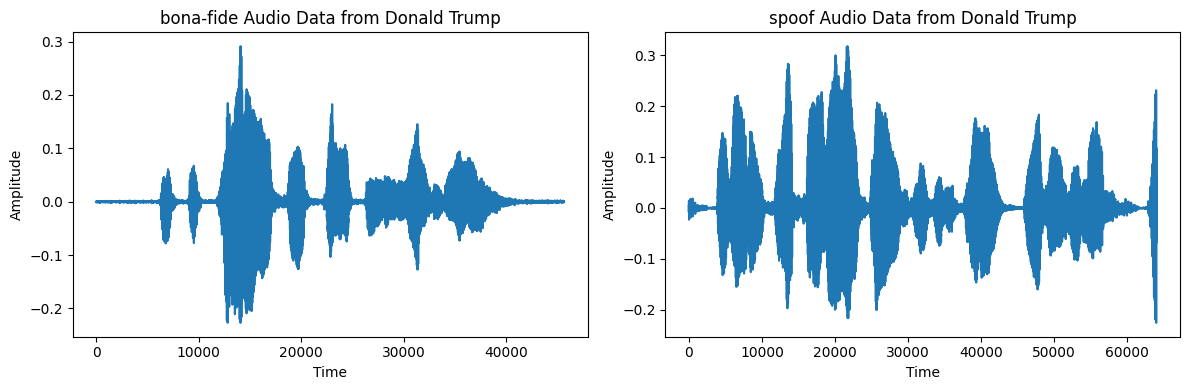

In [ ]:
visualize_data(df_trump, 'audio')

In [ ]:
df_red = pd.read_pickle('/content/drive/My Drive/Colab_Notebooks/NLP/red_noise_dataset_training.pkl')
df_trump_red = df_red[df_red['speaker'] == 'Donald Trump']

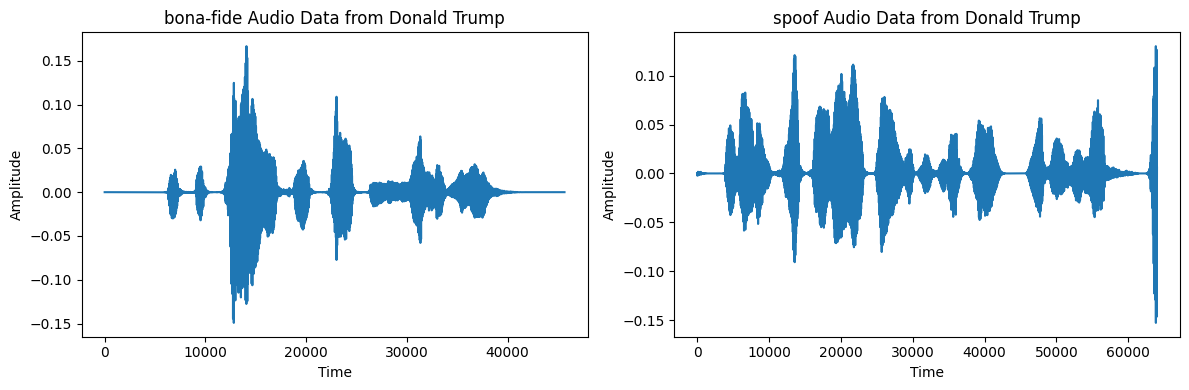

In [ ]:
visualize_data(df_trump_red, 'audio')

In [ ]:
visualize_data(df_trump, 'audio')
visualize_data(df_trump, 'spectogram')
visualize_data(df_trump, 'MFCC')

# 5. Data Preparation for Training

* split data into train, validation and test
* normalize data
* define training model
* compile and train the model

## load the data

In [ ]:
# load data
def load_data(data_path):
  data = np.load(data_path, allow_pickle=True)
  loaded_features = data['spectrograms']
  loaded_labels = data['labels']
  return loaded_features, loaded_labels

In [ ]:
#load mel spec with noise
data_path_mel = '/content/drive/My Drive/Colab_Notebooks/NLP/data_melspec.npz'
loaded_features, loaded_labels = load_data(data_path_mel)
print("Geladene Features:", loaded_features.shape)

Geladene Features: (23632, 128, 126)


In [ ]:
#load MFCC with noise
data_path_mfcc = '/content/drive/My Drive/Colab_Notebooks/NLP/data_mfcc.npz'
loaded_features, loaded_labels = load_data(data_path_mfcc)
print("Geladene Features:", loaded_features.shape)

Geladene Features: (23632, 20, 126)


In [ ]:
#load mel spec no noise
data_path_mel_red = '/content/drive/My Drive/Colab_Notebooks/NLP/data_melspec_red.npz'
loaded_features, loaded_labels = load_data(data_path_mel_red)
print("Geladene Features:", loaded_features.shape)

Geladene Features: (23632, 128, 126)


In [ ]:
#load MFCC no noise
data_path_mfcc_red = '/content/drive/My Drive/Colab_Notebooks/NLP/data_mfcc_red.npz'
loaded_features, loaded_labels = load_data(data_path_mfcc_red)
print("Geladene Features:", loaded_features.shape)

## Split and normalize the data

In [ ]:
# split data into 70% traindata, 30% rest (validation + test)
X_train, X_rest, y_train, y_rest = train_test_split(loaded_features, loaded_labels, test_size=0.3, random_state=42)

# split rest into 20% validation and 10% testdata
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.1, random_state=42)

In [ ]:
# Normalisierung der Daten: Z-Score Normalisierung
def normalize_spectrograms(train_data, norm_data):
    # Calculate mean and standard deviation from the training data
    mean = np.mean([np.mean(spec, axis=(0, 1)) for spec in train_data])
    std = np.std([np.std(spec, axis=(0, 1)) for spec in train_data])
    # Normalize the data
    normalized_data = np.array([(spec - mean) / std for spec in norm_data])

    return normalized_data

In [ ]:
# Normalisiere die Trainings-, Validierungs- und Testdaten mit den berechneten Werten
X_train = normalize_spectrograms(X_train, X_train)
X_val = normalize_spectrograms(X_train, X_val)
X_test = normalize_spectrograms(X_train, X_test)

In [ ]:
#use label encoder to get the unique clases & transform them into numerical data
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)
# Switch labels to one-hot encoded
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [ ]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (16542, 128, 126)
y_train shape: (16542, 2)
X_val shape: (6381, 128, 126)
y_val shape: (6381, 2)


In [ ]:
# Features reshapen to add channel
X_train = X_train[..., np.newaxis]  # (samples, height, width) → (samples, height, width, 1)
X_val = X_val[..., np.newaxis]

# 1. Train CNN model from scratch

## Define and train the model

In [ ]:
# define model architecture
def model_cnn(num_classes, dropout_rate, input_shape):
    model = Sequential()
    model.add(Input(shape= input_shape))
    #Convolutional Layer
    model.add(Conv2D(32, (3,3), activation='relu'))
    #Max Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=2))
    #Flatten Layer
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_rate))
    #Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    return model

# GridSearch

In [ ]:
# Subset for GridSearch (10% of trainingsdata)
X_train_small, _, y_train_small, _ = train_test_split(X_train, y_train, test_size=0.95, random_state=42)

print("X_train shape:", X_train_small.shape)
print("y_train shape:", y_train_small.shape)

X_train shape: (708, 128, 109, 1)
y_train shape: (708, 2)


In [ ]:
#find the best hyperparameters with GridSearch
model = KerasClassifier(model=model_cnn, verbose=0)

# Parameter für die Grid Search
param_grid = {
    'model__num_classes': [2],
    'model__input_shape': [X_train[0].shape],
    'model__optimizer': [Adam, SGD],
    'model__learning_rate': [0.01, 0.001],
    'model__dropout_rate': [0.3, 0.5],
    'batch_size': [32, 64, 128],
    'epochs': [10, 20, 30]
}

# Grid Search starten
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy')
grid_result = grid.fit(X_train_small, y_train_small)

In [ ]:
df_grid_results = pd.DataFrame(grid_result.cv_results_)
df_grid_results.to_csv('/content/drive/My Drive/Colab_Notebooks/NLP/grid_search_results.csv', sep=';')

In [ ]:
df_grid_best_params = pd.DataFrame(grid_result.best_params_)
df_grid_best_params.to_csv('/content/drive/My Drive/Colab_Notebooks/NLP/grid_search_best_params.csv', sep=';')

In [ ]:
#grid_result = pd.read_csv('grid_search_results.csv')
print(grid_result.best_params_)
print(grid_result.best_score_)

# Train

In [ ]:
#define model and get model summary / parameters //
model = model_cnn(2, 0.5, X_train[0].shape)

optimizer = 'adam'

#compile model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 124, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 124992)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      15,999,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,999,682 (61.03 MB)

 Trainable params: 15,999,682 (61.03 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 347s 666ms/step - accuracy: 0.5958 - loss: 8.1095 - val_accuracy: 0.6469 - val_loss: 1.4093
Epoch 2/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 365s 634ms/step - accuracy: 0.7209 - loss: 0.5293 - val_accuracy: 0.7659 - val_loss: 1.7635
Epoch 3/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 383s 635ms/step - accuracy: 0.7964 - loss: 0.3828 - val_accuracy: 0.7643 - val_loss: 2.2172
Epoch 4/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 323s 626ms/step - accuracy: 0.8406 - loss: 0.2823 - val_accuracy: 0.9130 - val_loss: 0.8532
Epoch 5/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 388s 637ms/step - accuracy: 0.8453 - loss: 0.2605 - val_accuracy: 0.9287 - val_loss: 0.5903
Epoch 6/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 381s 635ms/step - accuracy: 0.8671 - loss: 0.2287 - val_accuracy: 0.9503 - val_loss: 0.7945
Epoch 7/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 375s 622ms/step - accuracy: 0.9045 - loss: 0.1966 - val_accuracy: 0.9229 - val_loss: 1.3891
Epoch 8/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 320s 619ms/step - accuracy: 0.9113 -

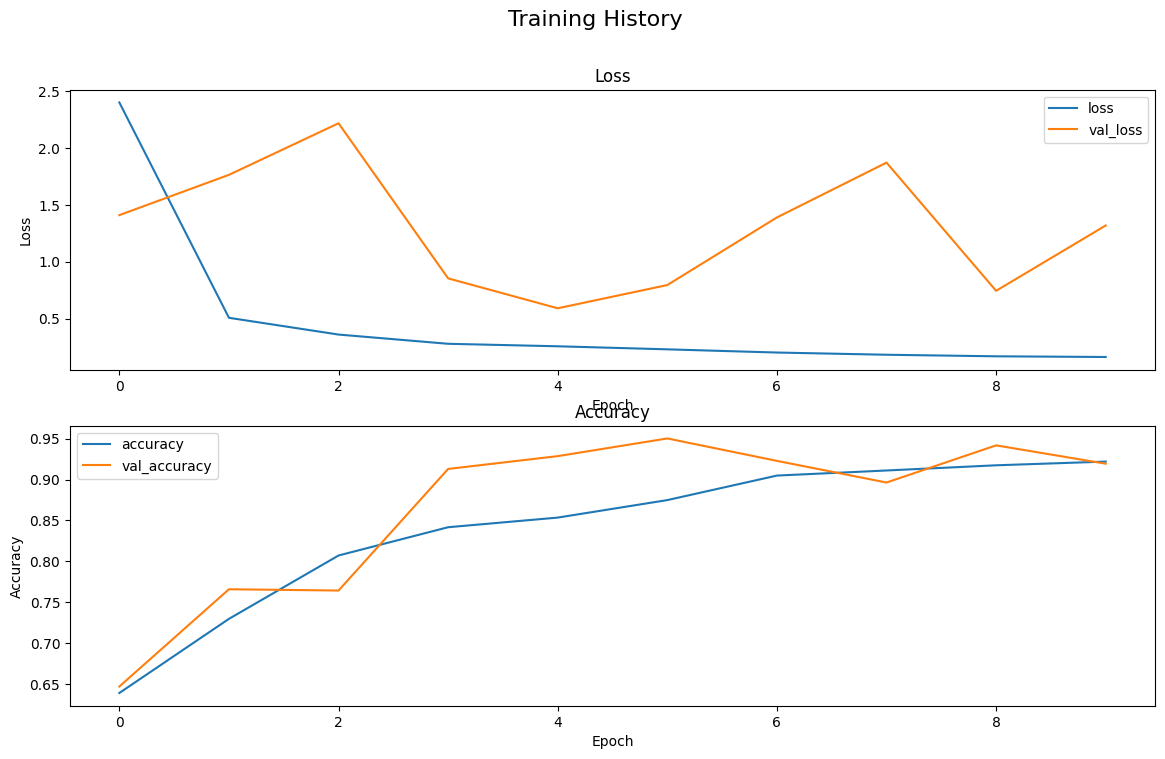

In [ ]:
EPOCHS = 10
BATCH_SIZE = 32

#define early stopping for monitoring and prevention of overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#train model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping])

# Plot the training history
fig, axs = plt.subplots(2)
fig.set_size_inches(14, 8)
fig.suptitle('Training History', fontsize=16)
axs[0].plot(history.epoch, history.history['loss'], history.history['val_loss'])
axs[0].set(title='Loss', xlabel='Epoch', ylabel='Loss')
axs[0].legend(['loss', 'val_loss'])
axs[1].plot(history.epoch, history.history['accuracy'], history.history['val_accuracy'])
axs[1].set(title='Accuracy', xlabel='Epoch', ylabel='Accuracy')
axs[1].legend(['accuracy', 'val_accuracy'])
plt.show()

In [ ]:
# saving the model
MODEL_PATH = '/content/drive/My Drive/Colab_Notebooks/NLP/'
#model.save("audio_classifier_moise_reduced.h5")
keras.saving.save_model(model, MODEL_PATH + 'my_model_melspec_red.keras')

# 6. Predictions on test set


In [ ]:
# Predict using the loaded model
y_pred = model.predict(X_test)
# Convert probabilities to predicted classes
y_pred_classes = np.argmax(y_pred, axis=1)

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

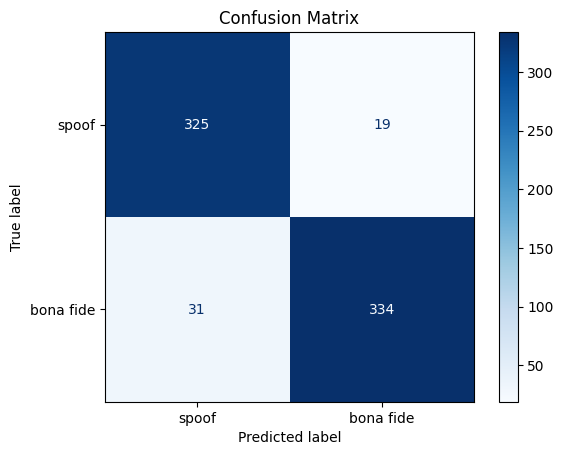

In [ ]:
# CONFUSION MATRIX

cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

# Display the confusion matrix
classes = ["spoof", "bona fide"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

sources:
- notebooks from class
- https://deepfake-total.com/in_the_wild
- https://www.kaggle.com/code/alperkaraca1/deep-fake-voice-recognition/notebook
- https://github.com/sksmta/audio-deepfake-detection/blob/main/main.ipynb